In [1]:
pip install -U albumentations

In [ ]:
!git clone https://github.com/thsant/wgisd

In [3]:
import os

ROOT_DIR = './wgisd'
DATA_DIR = os.path.join(ROOT_DIR, 'data')

# idx_to_class = ['__background__', 'CDY', 'CFR', 'CSV', 'SVB', 'SYH']
idx_to_class = ['__background__', 'GRAPE']
class_to_idx = {v: i for (i, v) in enumerate(idx_to_class)}

# Preprocess & split data

In [4]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np

def get_images():
  train_images = []
  val_images = []
  test_images = []

  with open(os.path.join(ROOT_DIR, 'train.txt')) as f:
    train_images = [name+".jpg" for name in f.read().split("\n") if name]

  with open(os.path.join(ROOT_DIR, 'test.txt')) as f:
    test_images = [name+".jpg" for name in f.read().split("\n") if name]

  # train_images, val_images = train_test_split(
  #     train_images, 
  #     train_size=0.8, 
  #     stratify=[image[:3] for image in train_images])
  
  train_images, val_images = train_test_split(
      train_images, 
      train_size=0.8)
  
  return train_images, val_images, test_images

def cxcywh_to_xy(box, img_width, img_height):
  [cx, cy, w, h] = box
  xmin = np.clip((cx - (w/2)), 0, img_width)
  xmax = np.clip((cx + (w/2)), 0, img_width)
  ymin = np.clip((cy - (h/2)), 0, img_height)
  ymax = np.clip((cy + (h/2)), 0, img_height)
  return [xmin, ymin, xmax, ymax]

# returns array
# 
# each array element has
# 
# image: name of image
# 
# boxes: bounding boxes in xmin, xmax, ymin, ymax format 
# where x and y are in range of image width and height respectively.
# 
# category_id: all bounding boxes in image have same category
# 
def get_data(images):
  data = []
  for image in images:
    # category_id = class_to_idx[image[:3]]
    category_id = 1
    
    im = Image.open(os.path.join(DATA_DIR, image))
    width = im.width
    height = im.height
    
    label_file = image[:-3]+"txt"
    
    boxes = []
    
    with open(os.path.join(DATA_DIR, label_file)) as f:
      for line in f:
  
        bbox = [float(part) for part in line.split(" ")][1:]
    
        bbox[0] = bbox[0] * width
        bbox[1] = bbox[1] * height
        bbox[2] = bbox[2] * width
        bbox[3] = bbox[3] * height
    
        bbox = cxcywh_to_xy(bbox, width, height)

        boxes.append(bbox)

    data.append({
        'image': image,
        'boxes': boxes,
        'category_id': category_id    
    })
  return data

[train_images, val_images, test_images] = get_images()
train_data = get_data(train_images)
val_data = get_data(val_images)
test_data = get_data(test_images)

# Create Dataset

In [5]:
import cv2
import numpy as np
import os
import torch

class GrapeDataset(object):
  def __init__(self, data_dir, data, transforms=None):
    self.data_dir = data_dir
    self.data = data
    self.transforms = transforms

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    item = self.data[idx]

    image_name = item['image']

    img = cv2.imread(os.path.join(self.data_dir, image_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img /= 255

    n = len(item['boxes'])

    boxes = torch.tensor(item['boxes'], dtype=torch.float32)

    category_id = item['category_id']
    labels = torch.full((n, ), category_id, dtype=torch.int64)

    if self.transforms is not None:
      transformed = self.transforms(image=img, bboxes=boxes, labels=labels)
      boxes = torch.tensor(transformed['bboxes'], dtype=torch.float32)
      labels = torch.tensor(transformed['labels'], dtype=torch.int64)
      img = transformed['image']

    if len(boxes) == 0:
      boxes = torch.zeros(0, 4, dtype=dtype.float32)
      labels = torch.zeros(0, dtype=torch.int64)
    
    areas = torch.tensor(
        [(box[2] - box[0]) * (box[3] - box[1]) for box in boxes],
        dtype=torch.float64
    )

    iscrowd = torch.zeros(len(boxes), dtype=torch.int64)

    target = {
        'boxes': boxes,
        'labels': labels,
        'areas': areas,
        'iscrowd': iscrowd,
        'image_id': torch.tensor([idx])
    }

    return img, target


In [6]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2;

transform = {
    'train': A.Compose([
      A.Resize(1356, 2048, always_apply=True, p=1.0),
      # A.HorizontalFlip(p=0.5),
      # A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
      # A.Blur(blur_limit=3),
      ToTensorV2(always_apply=True, p=1.0, transpose_mask=True),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])),
    
    'val': A.Compose([
      A.Resize(1356, 2048, always_apply=True, p=1.0),
      ToTensorV2(always_apply=True, p=1.0, transpose_mask=True),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])),

    'test': A.Compose([
      A.Resize(1356, 2048, always_apply=True, p=1.0),
      ToTensorV2(always_apply=True, p=1.0, transpose_mask=True),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])),
}

In [7]:
train_ds = GrapeDataset(DATA_DIR, train_data, transforms=transform['train'])
val_ds = GrapeDataset(DATA_DIR, val_data, transforms=transform['val'])
test_ds = GrapeDataset(DATA_DIR, test_data, transforms=transform['test'])

In [8]:
for x, y in train_ds:
  print(x.size())
  print(y.keys())
  print(y['boxes'].size())
  print(y['labels'].size())
  print(y['areas'].size())
  print(y['iscrowd'].size())
  print(y['image_id'].size())
  break

torch.Size([3, 1356, 2048])
dict_keys(['boxes', 'labels', 'areas', 'iscrowd', 'image_id'])
torch.Size([11, 4])
torch.Size([11])
torch.Size([11])
torch.Size([11])
torch.Size([1])


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def gen_colors(num_classes):
    np.random.seed(32)
    return [[np.random.randint(0, 255) for _ in range(3)] for _ in range(num_classes)]

COLORS = gen_colors(len(idx_to_class))

def draw_boxes(img, boxes, labels):
  # c,h,w => h,w,c
  # opencv draws correctly if color is between 0-255
  img = np.ascontiguousarray(img.permute(1, 2, 0).numpy()*255)

  for i in range(len(boxes)):
    color = COLORS[labels[i]]
    img = cv2.rectangle(img, 
                  (int(boxes[i][0]), int(boxes[i][1])), 
                  (int(boxes[i][2]), int(boxes[i][3])),
                  color,
                  5)

  # matplotlib expects float between 0,1
  return img/255

def draw_and_show(img, boxes, labels):
  img = draw_boxes(img, boxes, labels)
  # cv2_imshow(img)
  w = img.shape[1]
  h = img.shape[0]
  ppi = 150

  f, ax = plt.subplots(1, 1, figsize=(int(w/ppi), int(h/ppi)))
  ax.set_axis_off()
  ax.imshow(img, aspect='auto')
  return img

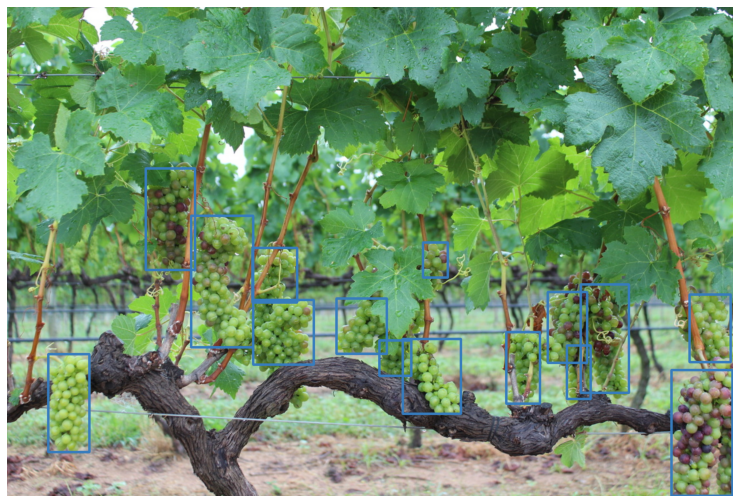

In [10]:
x, y = train_ds[8]
draw_and_show(x, y['boxes'], y['labels']);

# Device Helper


In [11]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(d, device) for d in data]
  if isinstance(data, dict):
    return {k: to_device(v, device) for (k, v) in data.items()}
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  
  def __iter__(self):
    for data in self.dl:
      yield to_device(data, self.device)

  def __len__(self):
    return len(self.dl)

# Dataloader

In [12]:
from torch.utils.data import DataLoader

BATCH_SIZE=8

def collate_fn(batch):
  return tuple(zip(*batch))

train_dl = DeviceDataLoader(
    DataLoader(train_ds,
               batch_size=BATCH_SIZE,
               shuffle=True,
               collate_fn=collate_fn,
               pin_memory=False),
    device,
)


val_dl = DeviceDataLoader(
    DataLoader(val_ds,
               batch_size=BATCH_SIZE,
               shuffle=True,
               collate_fn=collate_fn,
               pin_memory=False),
    device,
)


test_dl = DeviceDataLoader(
    DataLoader(test_ds,
               batch_size=BATCH_SIZE,
               shuffle=True,
               collate_fn=collate_fn,
               pin_memory=False),
    device,
)

# Create Model, Try passing data to model

In [13]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

def get_model():
  model = fasterrcnn_resnet50_fpn(
      pretrained_backbone=True,
      num_classes=len(idx_to_class),
      trainable_backbone_layers=5
  )
  model = to_device(model, device)
  return model

In [ ]:
model = get_model()

model.train()

for x, y in train_dl:
  res = model(x, y)
  print(res)
  break

del model

In [ ]:
model = get_model()

model.eval()

for x, y in train_dl:
  res = model(x, y)
  print(res[0].keys())
  break

del model

# Train

In [14]:
import numpy as np

def iou(box1, box2):
  xmin1, ymin1, xmax1, ymax1 = box1  
  xmin2, ymin2, xmax2, ymax2 = box2

  xmin = max(xmin1, xmin2)
  xmax = min(xmax1, xmax2)
  ymin = max(ymin1, ymin2)
  ymax = min(ymax1, ymax2)

  if xmin > xmax or ymin > ymax:
    return 0

  intersection_area = (xmax-xmin) * (ymax-ymin)
  box1_area = ((xmax1-xmin1) * (ymax1-ymin1))
  box2_area = ((xmax2-xmin2) * (ymax2-ymin2))
  union_area = box1_area + box2_area - intersection_area
  
  return intersection_area / union_area


def map_iou(boxes_true, boxes_pred, scores, thresholds=[0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]):
  
  if len(boxes_true) == 0 and len(boxes_pred) == 0:
    return None
  
  assert boxes_true.shape[1] == 4 or boxes_pred.shape[1] == 4, "boxes should be 2D arrays with shape[1]=4"
  if len(boxes_pred):
    assert len(scores) == len(boxes_pred), "boxes_pred and scores should be same length"
    # sort boxes_pred by scores in decreasing order
    boxes_pred = boxes_pred[np.argsort(scores)[::-1], :]

  map_total = 0

  for t in thresholds:
    matched_bt = set()
    tp, fn = 0, 0
    for i, bt in enumerate(boxes_true):
      matched = False
      for j, bp in enumerate(boxes_pred):
        match_iou = iou(bt, bp)
        if match_iou >= t and not matched and j not in matched_bt:
          matched = True
          tp += 1
          matched_bt.add(j)
      if not matched:
        fn += 1
    fp = len(boxes_pred) - len(matched_bt)
    ap = tp / (tp + fn + fp)
    map_total += ap

  return map_total / len(thresholds)

In [15]:
# quick test to see if iou is working
box1 = [100, 100, 300, 300]
box2 = [100, 100, 400, 300]
assert iou(box1, box2) == (2/3)
assert map_iou(
    np.array([box1]), 
    np.array([box2]), 
    np.array([0.9]), 
    [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
) == 0.75

In [16]:
from torch import optim

iou_thresholds = np.arange(0.3, 0.9, 0.1)

epochs = 100

model = get_model()

params = [param for param in model.parameters() if param.requires_grad]


# optimizer = torch.optim.SGD(params, lr=0.00001, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(
    params,
    lr=1e-4,
)

# scheduler = optim.lr_scheduler.StepLR(optimizer,
#                                       step_size=3,
#                                       gamma=0.1)

# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=0.000001)

def train_one_epoch(model, train_dl, optimizer):
  torch.cuda.empty_cache()
  
  epoch_loss = 0
  epoch_samples = 0

  for batch_index, batch in enumerate(train_dl):
  
    xb, yb = batch
    epoch_samples += len(xb)
  
    model.train()
    optimizer.zero_grad()
  
    loss_dict = model(xb, yb)
    batch_loss = sum(loss for loss in loss_dict.values())
    if (batch_index % 10) == 0:
      loss_classifier = loss_dict['loss_classifier']
      loss_box_reg = loss_dict['loss_box_reg']
      loss_objectness = loss_dict['loss_objectness']
      loss_rpn_box_reg = loss_dict['loss_rpn_box_reg']
      print(f"Batch [{batch_index}] {batch_loss.item():0.4f} {loss_classifier.item():0.4f} {loss_box_reg.item():0.4f} {loss_objectness.item():0.4f} {loss_rpn_box_reg.item():0.4f}")

    batch_loss.backward()
    optimizer.step()
  
    epoch_loss += (batch_loss.item() * len(xb))
    torch.cuda.empty_cache()

  return epoch_loss / epoch_samples;

def evaluate(model, dataloader, iou_thresholds):

  model.eval()

  with torch.no_grad():
    map_total = 0
    total_images = 0
    
    for i, batch in enumerate(dataloader):
      xb, yb = batch
      preds = model(xb, yb)

      for j in range(len(xb)):
        boxes_true = yb[j]['boxes'].cpu().numpy()
        boxes_pred = preds[j]['boxes'].cpu().numpy()
        scores = preds[j]['scores'].cpu().numpy()
        mAP = map_iou(boxes_true, boxes_pred, scores, iou_thresholds)
        
        if mAP is not None:
          map_total += mAP
          total_images += 1
    
    map_total /= total_images

    return map_total

def train():
  for epoch in range(1, epochs+1):
    print(f"Epoch [{epoch}/{epochs}] Start")
    epoch_loss = train_one_epoch(model, train_dl, optimizer)
    print(f"Epoch [{epoch}/{epochs}] Loss {epoch_loss:0.4f}")

    if epoch % 5 == 0:
      mAP = evaluate(model, val_dl, iou_thresholds)
      print(f"Epoch [{epoch}/{epochs}] map {mAP:0.4f}")
    # scheduler.step()
    print("")

In [17]:
torch.cuda.empty_cache()

In [18]:
train()

Epoch [1/100] Start
Batch [0] 1.5815 0.7003 0.1167 0.6893 0.0752
Batch [10] 1.3927 0.3967 0.6485 0.2623 0.0852
Batch [20] 1.5149 0.5087 0.8236 0.1144 0.0682
Epoch [1/100] Loss 1.6278

Epoch [2/100] Start
Batch [0] 1.4110 0.4548 0.7588 0.1000 0.0974
Batch [10] 1.3596 0.4520 0.7249 0.1041 0.0785
Batch [20] 1.3137 0.4162 0.7162 0.1027 0.0786
Epoch [2/100] Loss 1.3591

Epoch [3/100] Start
Batch [0] 1.1987 0.3912 0.6724 0.0854 0.0497
Batch [10] 1.2282 0.3954 0.6871 0.0794 0.0663
Batch [20] 1.1542 0.3655 0.6403 0.0824 0.0659
Epoch [3/100] Loss 1.2106

Epoch [4/100] Start
Batch [0] 1.1623 0.3876 0.6429 0.0730 0.0589
Batch [10] 1.0992 0.3460 0.6477 0.0487 0.0567
Batch [20] 1.1602 0.3864 0.6452 0.0747 0.0539
Epoch [4/100] Loss 1.1328

Epoch [5/100] Start
Batch [0] 1.0913 0.3591 0.6420 0.0411 0.0491
Batch [10] 0.9855 0.3342 0.5637 0.0505 0.0370
Batch [20] 0.8756 0.2916 0.5009 0.0416 0.0414
Epoch [5/100] Loss 1.0491
Epoch [5/100] map 0.1667

Epoch [6/100] Start
Batch [0] 0.9528 0.3167 0.5329 0.04

# Save Model

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [20]:
!mkdir -p /gdrive/My\ Drive/wgisd

In [21]:
torch.save(model.state_dict(), '/gdrive/My Drive/wgisd/fasterrcnn_resnet50.pt')

# Try

In [22]:
model = get_model()

In [23]:
model.load_state_dict(torch.load('/gdrive/My Drive/wgisd/fasterrcnn_resnet50.pt'))

<All keys matched successfully>

In [24]:
evaluate(model, val_dl, iou_thresholds)

0.533513806613855

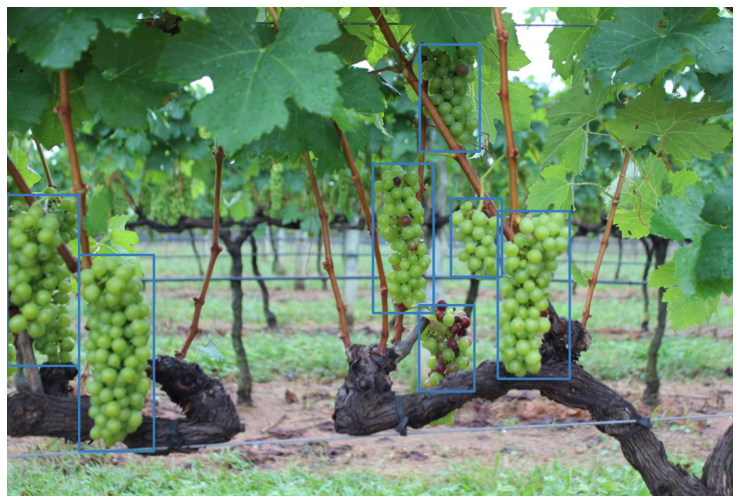

In [25]:
from albumentations.pytorch.functional import img_to_tensor

def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img /= 255
    # h, w, c => c, h, w
    img = torch.from_numpy(img.transpose(2, 0, 1))
    return img

def predict(model, img):
  img = to_device(img.unsqueeze(0), device)
  model.eval()
  ypred = model(img)[0]
  return ypred

def predict_and_draw(model, image_path):
  img = load_image(image_path)
  ypred = predict(model, img)
  draw_and_show(img, ypred['boxes'], ypred['labels'])

def get_random_test_image():
  index = np.random.choice(len(test_images), size=1, replace=False)[0]
  image = test_images[index]
  return os.path.join(DATA_DIR, image)  

predict_and_draw(model, get_random_test_image());